## Setup

This guide is for Azure ML / Azure machine learning studio but might work elsewere as well. The notebook server is Jupyterlab

- Create a compute instance (GPU)
- Go to terminal and checkout this git project
- Execute `conda env create -f environment.yaml` and `conda activate ldm `
- Create jupyter kernel for the conda env `ipython kernel install --user --name ldm --display-name "Python (ldm)"`
- Login to huggingface `huggingface-cli login`. You need to create a free hugging-face account to download the pretrained model. Also concent to the model at https://huggingface.co/CompVis/stable-diffusion-v1-4
- Reopen jupyterlab
- Select kernel


In [1]:
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
from torch import autocast
from IPython.display import display
from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

0it [00:00, ?it/s]

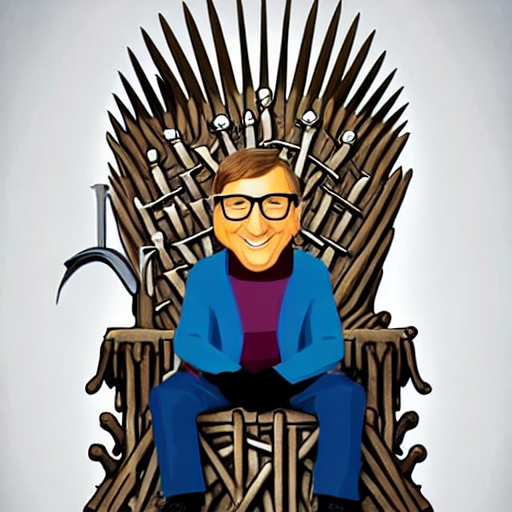

In [2]:


model_id = "CompVis/stable-diffusion-v1-4"
# Use the K-LMS scheduler here instead (uses less GPU memory)
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_scheduler=scheduler,  use_auth_token=True)
pipe = pipe.to("cuda")

#prompt = "surrealistic. emperor Bill Gates sitting on iron throne. dark eyes. skull mask. god rays. octane render. hyper realism. intricate details. cinematic. high detail"
prompt = "Bill Gates character with big oval shaped eyes sitting on iron throne. pixar. god rays. cute. vibrant. highly detailed. cartoon."
with autocast("cuda"):
    image = pipe(prompt,  num_inference_steps=50, guidance_scale=7.5)["sample"][0]  
 
display(image)

#image.save("astronaut_rides_horse.png")

In [4]:
#Grid it (Takes lot of GPU memory, could not run myself other that 2 images)

model_id = "CompVis/stable-diffusion-v1-4"
# Use the K-LMS scheduler here instead (uses less GPU memory)
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_scheduler=scheduler, use_auth_token=True)
pipe = pipe.to("cuda")

num_images = 2
prompt = ["Bill Gates character with big oval shaped eyes sitting on iron throne. pixar. god rays. cute. vibrant. highly detailed. cartoon."] * num_images
with autocast("cuda"):
    images = pipe(prompt)["sample"]

grid = image_grid(images, rows=1, cols=2)
display(grid)

0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.00 GiB (GPU 0; 11.17 GiB total capacity; 8.01 GiB already allocated; 1.23 GiB free; 9.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
 #Torch keeps losing memory, try to clean
import torch
torch.cuda.empty_cache()
# Not helping? run "nvidia-smi" on command line and kill the processes with fire = -9